In [19]:
import numpy as np
import matplotlib.pyplot as plt


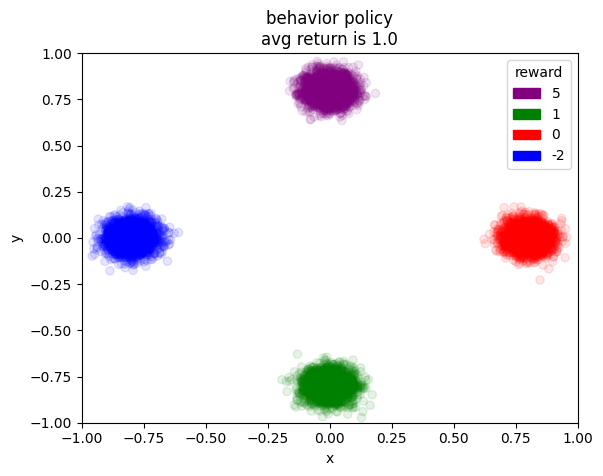

In [41]:
# generate data
M = 2500
a_l, a_u = -1, 1
mu_list = [(0, 0.8), (0, -0.8), (0.8, 0), (-0.8, 0)]
reward_list = [(5, "purple"), (1, "green"), (0, 'red'), (-2, 'blue')] # (reward, color)
a_sigma = ((0.05**2, 0), (0, 0.05**2))
# r_sigma = 0.5**2
r_sigma = 0

action_array, reward_array, color_array = [], [], [] 
for mu, reward in zip(mu_list, reward_list):
    actions = np.random.multivariate_normal(mu, a_sigma, M)
    actions = np.clip(actions, a_l, a_u)
    r, c = reward
    # rewards = np.ones(M, dtype=np.float32) * r
    rewards = np.random.normal(r, r_sigma, M)
    # colors = np.ones(M, dtype=np.int16) * c
    action_array.append(actions)
    reward_array.append(rewards)
    color_array.extend([c] * M)

transitions = {
    'actions': np.concatenate(action_array),
    'rewards': np.concatenate(reward_array),
    'colors': np.array(color_array), 
}

np.save('results/bandit.npy', transitions)

def vis(actions, colors, path=None, title=None, legend=None):
    scatter = plt.scatter(actions[:, 0], actions[:, 1],
         c=colors, alpha=0.1)
    plt.xlim(a_l, a_u)
    plt.ylim(a_l, a_u)
    plt.xlabel("x")
    plt.ylabel("y")
    if legend: 
        import matplotlib.patches as mpatches
        patches = [
            mpatches.Patch(color=c, label=str(r))
            for r, c in reward_list]
        plt.legend(handles=patches, title='reward')
    if title: plt.title(title)
    if path: plt.savefig(path)
    plt.show()

vis(transitions['actions'], transitions['colors'], 
    path='results/bandit_dist.jpg',
    title='behavior policy\navg return is 1.0',
    legend=1)

In [30]:

def sample(probs):
    probs = probs.squeeze() / np.sum(probs)
    size = probs.shape[0]
    idx = np.random.choice(size, size, p=probs, replace=True)
    return transitions['actions'][idx], transitions['rewards'][idx], transitions['colors'][idx]

    

# iter1
weight std is 0.85
Avg return is 3.17


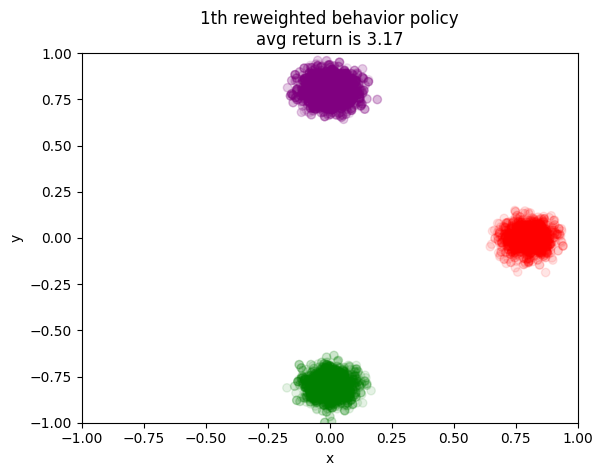

# iter2
weight std is 2.18
Avg return is 4.10


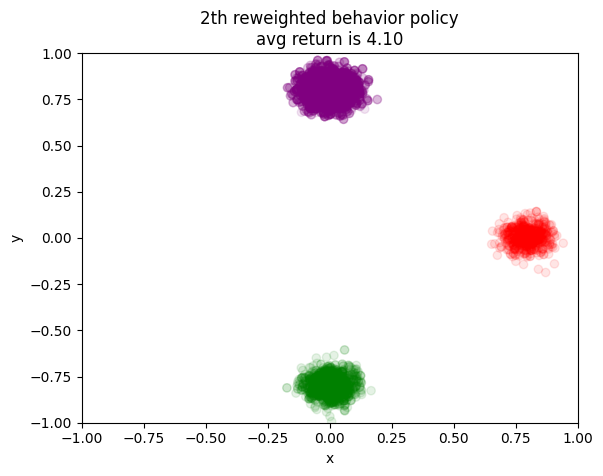

# iter3
weight std is 5.33
Avg return is 4.61


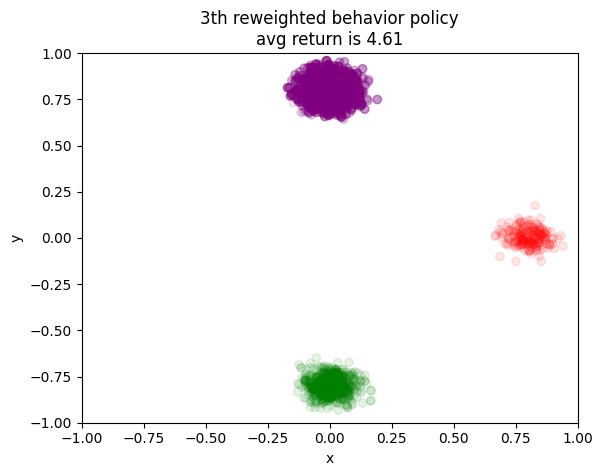

# iter4
weight std is 12.67
Avg return is 4.84


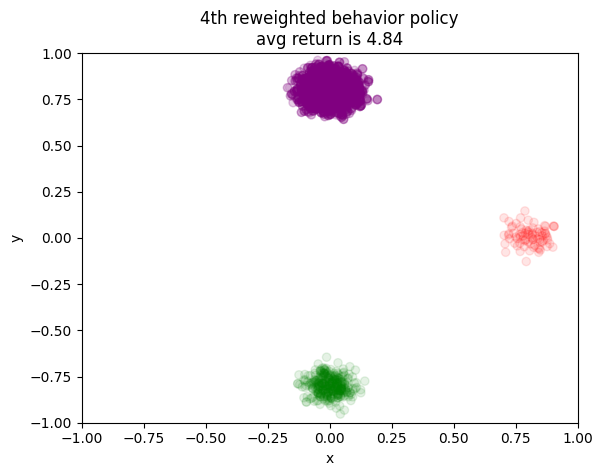

# iter5
weight std is 29.79
Avg return is 4.93


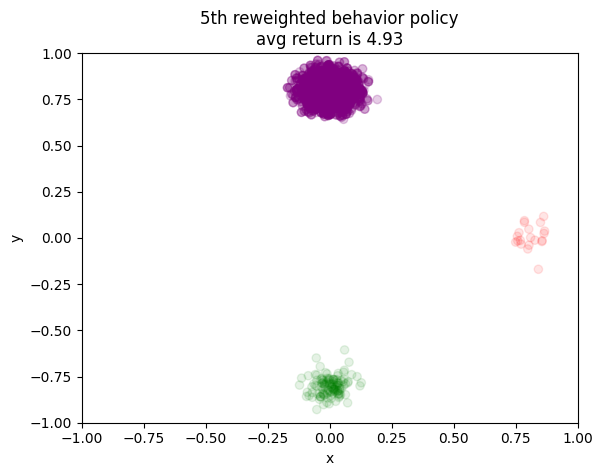

# iter6
weight std is 69.73
Avg return is 4.97


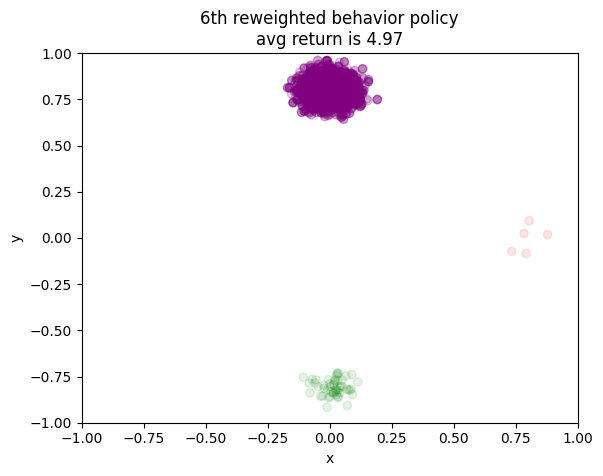

# iter7
weight std is 162.90
Avg return is 4.99


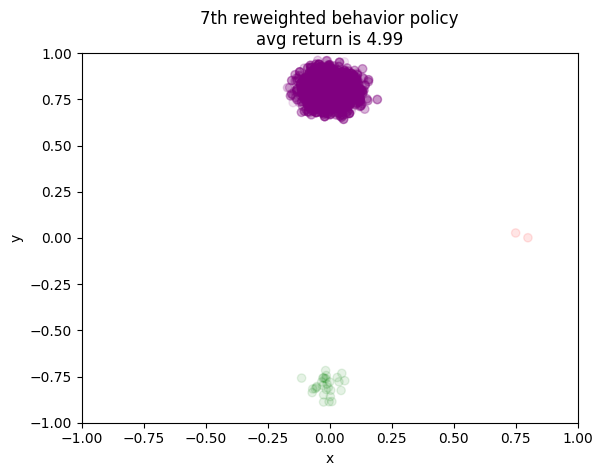

# iter8
weight std is 380.32
Avg return is 5.00


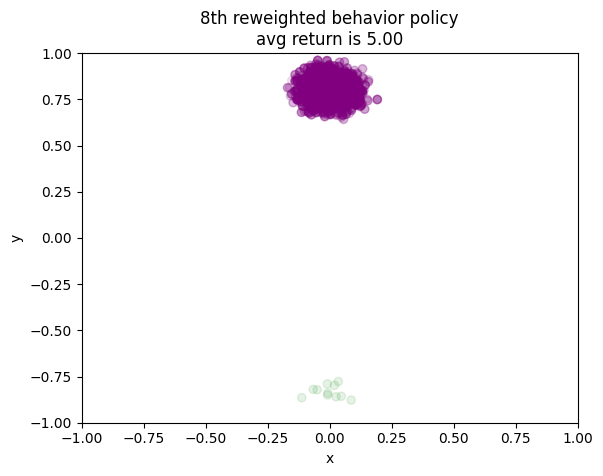

# iter9
weight std is 887.60
Avg return is 5.00


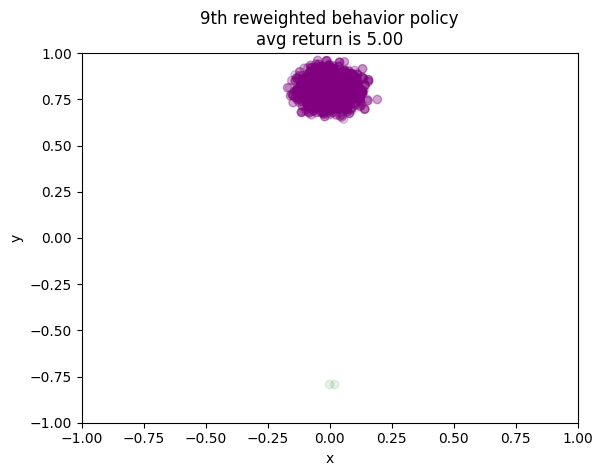

# iter10
weight std is 2071.27
Avg return is 5.00


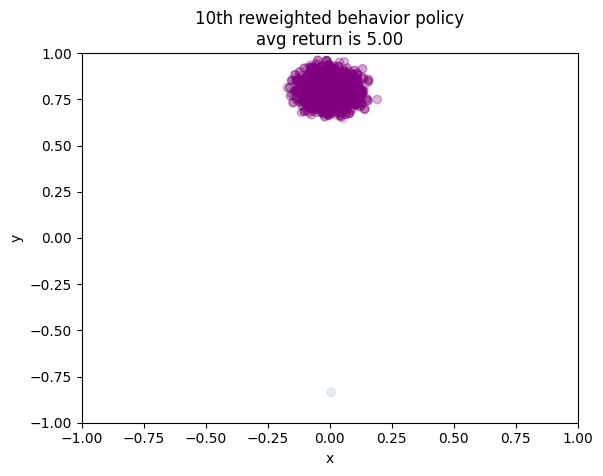

In [31]:
n_iter = 10
size = M * 4
weight = np.ones(size, dtype=np.float32)
prob = weight.squeeze() / np.sum(weight)
bc_eval_results = {'iter': n_iter}

for iter in range(1, n_iter+1):
    # train Q and V
    Q = transitions['rewards']
    V = np.dot(Q, prob)
    adv = Q - V
    # reset behavior policy, i.e., resampling
    padv = adv - adv.min()
    current_weight = padv / padv.sum() * size
    weight = weight * current_weight
    prob = weight / np.sum(weight)
    # log
    bc_eval_results[f'q'] = Q
    bc_eval_results[f'v{iter-1}'] = V
    bc_eval_results[f'weight{iter}'] = weight
    # visualize
    print(f'# iter{iter}')
    print(f'weight std is {weight.std():.2f}')
    print(f'Avg return is {np.dot(Q, prob):.2f}')
    actions, rewards, colors = sample(prob)
    vis(actions, colors, 
    path=f'results/bandit_dist_iter{iter}.jpg',
    title=f'{iter}th reweighted behavior policy\navg return is {np.dot(Q, prob):.2f}')


    

In [23]:
np.save('results/weight.npy', bc_eval_results)

# return-resample
weight std is 0.85
Avg return is 3.17


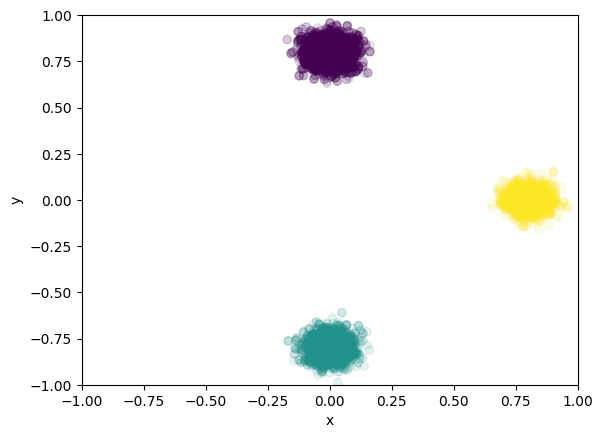

In [24]:
R = transitions['rewards']
R = R - R.min()
prob = R / R.sum()
weight = prob * size
# train Q and V
Q = transitions['rewards']
V = np.dot(Q, prob)
# visualize
print(f'# return-resample')
print(f'weight std is {weight.std():.2f}')
print(f'Avg return is {V:.2f}')
actions, rewards, colors = sample(prob)
vis(actions, colors, path=f'results/bandit_dist_return.jpg')